In [1]:
import wrf
from wrf import getvar, ALL_TIMES
import matplotlib as mpl
import cartopy.crs as ccrs
import netCDF4 as nc
# import cartopy.feature as cfeature
# import metpy.calc as mpcalc/
# from metpy.cbook import get_test_data
# from metpy.interpolate import cross_section
# from cartopy.io.img_tiles import Stamen
# from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from matplotlib import cm
import datetime
import numpy as np
import xarray as xr
import os
# from braceexpand import braceexpand
# import pandas as pd
import time
# import netCDF4 as nc
# import math
from math import cos, asin, sqrt, pi

# import glob
%matplotlib inline
%config InlineBackend.figure_format='retina'


### Set global variables
Anything that will be used throughout the script should be assigned here.

In [2]:
# Set the bounds you want to look at
lat_bound = [-5,5]			# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-5,5]
d0x = 2						# number of domains

### List of various functions that are used throughout the script

In [3]:
# Purpose: To grab the indicies that correspond to the times, latitudes, and longitudes of the WRF dataset file.

# Input:
	# file == path to the .nc file
	# times == np.datetime64 array [Start,End]
	# lats == np.array [south,north]
	# lons == np.array [west,east]

# Output:
	# time_ind, lat_ind, lon_ind == corresponds to the indicies of the times, lats, and lons provided within that file

# Example:
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# isel_ind(file, times, lats, lons)

def isel_ind(file,times,lats,lons):
	# Declare the variables
	time_ind = np.zeros(2, dtype=int)
	lat_ind = np.zeros(2, dtype=int)
	lon_ind = np.zeros(2, dtype=int)
	# Open the file
	ds = xr.open_dataset(file)
	# Times
	time_ind[0] = np.absolute(ds.XTIME.compute().values - (times[0])).argmin()
	time_ind[1] = np.absolute(ds.XTIME.compute().values - (times[1])).argmin()+1	# + 1 is because of the way argmin works
	# Latitudes
	lat_ind[0] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[0])).argmin()
	lat_ind[1] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[1])).argmin()+1
	# Longitude
	lon_ind[0] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[0])).argmin()
	lon_ind[1] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[1])).argmin()+1

	return time_ind, lat_ind, lon_ind

In [4]:
# Purpose: Opens a dataset with restrictive bounds to make opening large files less intensive

# Input:
	# file == path to the .nc file
	# time_ind == indicies (inclusive) of the dates you want to look at
	# lat_ind == indicies (inclusive) of the latitudes you want to look at
	# lon_ind == indicies (inclusive) of the longitudes you want to look at

# Output:
	# ds == dataset that corresponds to the times, lats, and lons provided.

# Example:
	# To get the indicies, I suggest using the function isel_ind() I have coded up in tandem with this function (see above).
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# time_ind, lat_ind, lon_ind = isel_ind(file, times, lats, lons)
	# ds = open_ds(file,time_ind,lat_ind,lon_ind)

def open_ds(file,time_ind,lat_ind,lon_ind):
	ds = xr.open_dataset(file).isel(
		Time=slice(time_ind[0],time_ind[1]),
		south_north=slice(lat_ind[0],lat_ind[1]),
		west_east=slice(lon_ind[0],lon_ind[1])
	)
	return ds

In [5]:
# This function finds the distance [km] between two coordinates in lat & lon
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [6]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components
# Example:
	# da_x = da_d01_U
	# da_y = da_d01_V
	# theta = pi/4	# 45° rotation anti-clockwise
	# da_d01_U_rotated, da_d01_V_rotated = rotate_vec(da_x, da_y, theta)

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if theta > 0:
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if theta < 0:
		da_x_rot = da_x*cos(-theta) + da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [7]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 		matrix in time, height, distance, and # of lines
		# 					or time, distance, and # of lines if using a 2-D variable
	# all_line_coords:	
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to south_north and west_east.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.XLAT[0,:,0]) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.XLAT[0,:,0]) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.XLONG[0,0,:]) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.XLONG[0,0,:]) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(south_north=line_coords[0,:]+spread[i], west_east=line_coords[1,:]-spread[i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,j,i] = data

		all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		all_line_coords[1,:,i] = line_coords[1,:]-spread[i]

	return da_cross, all_line_coords

In [8]:
def hov_diurnal(da, LT):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')

    if LT:
        # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
            # diurnal cycle of rain rate.
        array = np.zeros((da_avg.shape[1],24))
        # Loop through each longitude, look through all the timesteps and group them by hour,
            # and then average the values at each hour. Output the 1x24 array into the empty array
        for i in range(array.shape[0]):
            array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    else:
        array = da_avg.mean('west_east').groupby('XTIME.hour').mean()
    return array

In [9]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [10]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)
	local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.XTIME.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	return da

## Read in variables


### Control Data
This section opens stitched wrfout .nc files. The raw .nc file is much to large, so I have extracted variables from the large file into smaller .nc files that only contains one variable. To get these smaller .nc files, please refer to extract_variable.py and interp_variable.py function I have created. This section opens those files up and assigned them to a variable.

Temporal 10.5-day (2015 11-22-12UTC -> 2015 12-03-00UTC)

Below the section where I assigned file names, there is an option for you to only open up a smaller domain (spatial and temporal) if you are interetsed in a select region. This will save you a lot of computational time.

In [12]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
# parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/pre_conv_2015-11-25-03--11-26-12'
file_d01_raw = parent_dir + '/raw/d01'
file_d02_raw = parent_dir + '/raw/d02'
# 2-D data
file_d01_RR = parent_dir + '/L1/d01_RR'				# [mm/dt]
file_d02_RR = parent_dir + '/L1/d02_RR'				# [mm/dt]
file_d01_PSFC = parent_dir + '/L1/d01_PSFC'		    # [hPa]
file_d02_PSFC = parent_dir + '/L1/d02_PSFC'		    # [hPa]
file_d01_T2 = parent_dir + '/L1/d01_T2'		        # [K]
file_d02_T2 = parent_dir + '/L1/d02_T2'		        # [K]
file_d01_U10 = parent_dir + '/L1/d01_U10'		    # [m/s]
file_d02_U10 = parent_dir + '/L1/d02_U10'		    # [m/s]
file_d01_V10 = parent_dir + '/L1/d01_V10'		    # [m/s]
file_d02_V10 = parent_dir + '/L1/d02_V10'		    # [m/s]
# Raw data
file_d01_P = parent_dir + '/L1/d01_P'				# [mm/dt]
file_d02_P = parent_dir + '/L1/d02_P'				# [mm/dt]
# Interpolated data 
file_d01_U = parent_dir + '/L2/d01_interp_U'	        # [m/s]
file_d02_U = parent_dir + '/L2/d02_interp_U'	        # [m/s]
file_d01_V = parent_dir + '/L2/d01_interp_V'	        # [m/s]
file_d02_V = parent_dir + '/L2/d02_interp_V'	        # [m/s]
file_d01_QV = parent_dir + '/L2/d01_interp_QV'	        # [kg/kg]
file_d02_QV = parent_dir + '/L2/d02_interp_QV'	        # [kg/kg]
file_d01_CLDFRA = parent_dir + '/L2/d01_interp_CLDFRA'	# 
file_d02_CLDFRA = parent_dir + '/L2/d02_interp_CLDFRA'	# 
file_d01_LH = parent_dir + '/L2/d01_interp_LH'	        # [K/s]
file_d02_LH = parent_dir + '/L2/d02_interp_LH'	        # [K/s]
file_d01_LWAll = parent_dir + '/L2/d01_interp_LWAll'	# [K/s]
file_d02_LWAll = parent_dir + '/L2/d02_interp_LWAll'	# [K/s]
file_d01_LWClear = parent_dir + '/L2/d01_interp_LWClear'# [K/s]
file_d02_LWClear = parent_dir + '/L2/d02_interp_LWClear'# [K/s]
file_d01_SWAll = parent_dir + '/L2/d01_interp_SWAll'	# [K/s]
file_d02_SWAll = parent_dir + '/L2/d02_interp_SWAll'	# [K/s]
file_d01_SWClear = parent_dir + '/L2/d01_interp_SWClear'# [K/s]
file_d02_SWClear = parent_dir + '/L2/d02_interp_SWClear'# [K/s]
file_d01_Theta = parent_dir + '/L2/d01_interp_Theta'	# [K]
file_d02_Theta = parent_dir + '/L2/d02_interp_Theta'	# [K]
    # At single hPa levels
# file_d01_QV850 = parent_dir + '/L2/d01_interp_QV850'	# [kg/kg]
# file_d02_QV850 = parent_dir + '/L2/d02_interp_QV850'	# [kg/kg]
# file_d01_U850 = parent_dir + '/L2/d01_interp_U850'	# [m/s]
# file_d02_U850 = parent_dir + '/L2/d02_interp_U850'	# [m/s]
# file_d01_U200 = parent_dir + '/L2/d01_interp_U200'	# [m/s]
# file_d02_U200 = parent_dir + '/L2/d02_interp_U200'	# [m/s]

######################################################################################
################ Declare the bounds you want to specifically look at #################
#### All the data 
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-02T12')]
# lats = [-20, 20]
# lons = [80, 135]

#### Some of the data
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-03T00')]
times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-22T15')]
lats = [-7.5, 7.5]
lons = [90, 110]
######################################################################################
# Setup the indicies that will be used throughout
time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(file_d01_raw, times, lats, lons)
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(file_d02_raw, times, lats, lons)

# Raw datasets
start_time = time.perf_counter()
ds_d01 = open_ds(file_d01_raw,time_ind_d01,lat_ind_d01,lon_ind_d01)
ds_d02 = open_ds(file_d02_raw,time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')


# Coordinate dictionaries:
step2_time = time.perf_counter()
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

interp_P_levels_d01 = np.resize(interp_P_levels,(ds_d01.XLAT.shape[2],ds_d01.XLAT.shape[1],len(interp_P_levels)))
interp_P_levels_d01 = np.swapaxes(interp_P_levels_d01, 0, 2)
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    XTIME=('Time',ds_d01.XTIME.values),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )
interp_P_levels_d02 = np.resize(interp_P_levels,(ds_d02.XLAT.shape[2],ds_d02.XLAT.shape[1],len(interp_P_levels)))
interp_P_levels_d02 = np.swapaxes(interp_P_levels_d02, 0, 2)
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    XTIME=('Time',ds_d02.XTIME.values),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

# Function that can removes the bottom_top dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}
step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

###########################################################
################# Load in the variables ###################
###########################################################


##################### 3-D variables #######################

# ############ Interpolated zonal winds   [m/s] #############
# step2_time = time.perf_counter()
# # d01   # how I used to open data: ds = xr.open_dataset(file_d01_U).isel(Time=slice(0,t))
# ds = open_ds(file_d01_U,time_ind_d01,lat_ind_d01,lon_ind_d01)

# da_d01_U = ds['U'].compute()
# da_d01_U = da_d01_U.assign_coords(d01_coords)
# fill_value_f8 = da_d01_U.max()      # This is the fill_value meaning missing_data
# da_d01_U = da_d01_U.where(da_d01_U!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_U,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)
# # fill_value = da_d02_U.max()      # This is the fill_value meaning missing_data
# da_d02_U = da_d02_U.where(da_d02_U!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Interpolated Meridional winds   [m/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_V,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_V = ds['V'].compute()
# da_d01_V = da_d01_V.assign_coords(d01_coords)
# # fill_value = da_d01_V.max()      # This is the fill_value meaning missing_data
# da_d01_V = da_d01_V.where(da_d01_V!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_V,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)
# # fill_value = da_d02_V.max()      # This is the fill_value meaning missing_data
# da_d02_V = da_d02_V.where(da_d02_V!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated meridional winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Interpolated water vapor mixing ratio  [kg/kg] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_QV,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_QV = ds['QV'].compute()
# da_d01_QV = da_d01_QV.assign_coords(d01_coords)
# da_d01_QV = da_d01_QV.where(da_d01_QV!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_QV,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_QV = ds['QV'].compute()
# da_d02_QV = da_d02_QV.assign_coords(d02_coords)
# da_d02_QV = da_d02_QV.where(da_d02_QV!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud Fraction [0-1] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_CLDFRA,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_CLDFRA = ds['CLDFRA'].compute()
# da_d01_CLDFRA = da_d01_CLDFRA.assign_coords(d01_coords)
# da_d01_CLDFRA = da_d01_CLDFRA.where(da_d01_CLDFRA!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_CLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_CLDFRA = ds['CLDFRA'].compute()
# da_d02_CLDFRA = da_d02_CLDFRA.assign_coords(d02_coords)
# da_d02_CLDFRA = da_d02_CLDFRA.where(da_d02_CLDFRA!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Cloud fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Latent Heating [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LH,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LH = ds['LH'].compute()
# da_d01_LH = da_d01_LH.assign_coords(d01_coords)
# da_d01_LH = da_d01_LH.where(da_d01_LH!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LH,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LH = ds['LH'].compute()
# da_d02_LH = da_d02_LH.assign_coords(d02_coords)
# da_d02_LH = da_d02_LH.where(da_d02_LH!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Latent heating loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Potential Temperature [K] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_Theta,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_Theta = ds['Theta'].compute()
# da_d01_Theta = da_d01_Theta.assign_coords(d01_coords)
# da_d01_Theta = da_d01_Theta.where(da_d01_Theta!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_Theta,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Theta = ds['Theta'].compute()
# da_d02_Theta = da_d02_Theta.assign_coords(d02_coords)
# da_d02_Theta = da_d02_Theta.where(da_d02_Theta!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWAll = ds['LWAll'].compute()
# da_d01_LWAll = da_d01_LWAll.assign_coords(d01_coords)
# da_d01_LWAll = da_d01_LWAll.where(da_d01_LWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWAll = ds['LWAll'].compute()
# da_d02_LWAll = da_d02_LWAll.assign_coords(d02_coords)
# da_d02_LWAll = da_d02_LWAll.where(da_d02_LWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWClear = ds['LWClear'].compute()
# da_d01_LWClear = da_d01_LWClear.assign_coords(d01_coords)
# da_d01_LWClear = da_d01_LWClear.where(da_d01_LWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWClear = ds['LWClear'].compute()
# da_d02_LWClear = da_d02_LWClear.assign_coords(d02_coords)
# da_d02_LWClear = da_d02_LWClear.where(da_d02_LWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWAll = ds['SWAll'].compute()
# da_d01_SWAll = da_d01_SWAll.assign_coords(d01_coords)
# da_d01_SWAll = da_d01_SWAll.where(da_d01_SWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWAll = ds['SWAll'].compute()
# da_d02_SWAll = da_d02_SWAll.assign_coords(d02_coords)
# da_d02_SWAll = da_d02_SWAll.where(da_d02_SWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWClear = ds['SWClear'].compute()
# da_d01_SWClear = da_d01_SWClear.assign_coords(d01_coords)
# da_d01_SWClear = da_d01_SWClear.where(da_d01_SWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWClear = ds['SWClear'].compute()
# da_d02_SWClear = da_d02_SWClear.assign_coords(d02_coords)
# da_d02_SWClear = da_d02_SWClear.where(da_d02_SWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud-Radiative Forcing Calculations ############
# # Longwave
# da_d01_LWCRF = da_d01_LWAll - da_d01_LWClear
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear
# # Shortwave
# da_d01_SWCRF = da_d01_SWAll - da_d01_SWClear
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear
# # Total
# da_d01_TotalCRF = da_d01_LWCRF + da_d01_SWCRF
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF

##################### 2-D variables #######################

############ Rain Rate     [mm/hr] ############
step2_time = time.perf_counter()
# d01
ds = open_ds(file_d01_RR,time_ind_d01,lat_ind_d01,lon_ind_d01)
da_d01_RR = ds['RR'].compute()
da_d01_RR = da_d01_RR.assign_coords(without_keys(d01_coords,'bottom_top'))
# d02
ds = open_ds(file_d02_RR,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_RR = ds['RR'].compute()
da_d02_RR = da_d02_RR.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Surface Pressure     [hPa] ############
step2_time = time.perf_counter()
# d01
ds = open_ds(file_d01_PSFC,time_ind_d01,lat_ind_d01,lon_ind_d01)
da_d01_PSFC = ds['PSFC'].compute()
da_d01_PSFC = da_d01_PSFC.assign_coords(without_keys(d01_coords,'bottom_top'))
# d02
ds = open_ds(file_d02_PSFC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_PSFC = ds['PSFC'].compute()
da_d02_PSFC = da_d02_PSFC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Surface Pressure loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Detection of land & water  ############
step2_time = time.perf_counter()
# d01
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# d02
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0

step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Terrain Height    [m]  ############
step2_time = time.perf_counter()
# d01
da_d01_TOPO = ds_d01['HGT'].sel(Time=slice(1)).compute().squeeze()
# d02
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()

step1_time = time.perf_counter()
print('Terrain Height loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Temporal and Spatial variables ############
# step2_time = time.perf_counter()
# da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]
# da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]
# step1_time = time.perf_counter()
# print('Tempospatial variables loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 0.5870630200952291 seconds
Created coordinate dictionaries ✓ 0.2073144381865859 seconds
Rain rates loaded ✓ 0.5504442546516657 seconds
Surface Pressure loaded ✓ 0.5114129297435284 seconds
Landmask loaded ✓ 0.35202926583588123 seconds
Terrain Height loaded ✓ 0.5627847136929631 seconds
Domain d01 & d02 ✓ 2.7716025011613965 seconds


#### Add Local Time Coordinate

In [ ]:
# d01
da_d01_U850 = assign_LT_coord(da_d01_U850)
da_d01_QV850 = assign_LT_coord(da_d01_QV850)
da_d01_RR = assign_LT_coord(da_d01_RR)
da_d01_LWUPT = assign_LT_coord(da_d01_LWUPT)

# d02
da_d02_U850 = assign_LT_coord(da_d02_U850)
da_d02_QV850 = assign_LT_coord(da_d02_QV850)
da_d02_RR = assign_LT_coord(da_d02_RR)
da_d02_LWUPT = assign_LT_coord(da_d02_LWUPT)


In [ ]:
# cd into the directory with your cross-sectional datasets to make the file paths when using xr.open_dataset a lot shorter
# os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/L3')
os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/pre_conv_2015-11-25-03--11-26-12/L3')
# Set the parameters for the specific island
    # Sumatra
start_coord		= [-1.8,103.8]
end_coord 		= [-5.8,99.8]
width			= 1.5
dx 				= 0.025
theta           = pi/4
## Load in the variables
start_time = time.perf_counter()
# Normal Wind [m/s]
da_d01_NormalWind_cross = xr.open_dataset('d01_cross_NormalWind')['NormalWind'].compute()
da_d02_NormalWind_cross = xr.open_dataset('d02_cross_NormalWind')['NormalWind'].compute()
# Rain Rate [mm/day]
da_d01_RR_cross = xr.open_dataset('d01_cross_RR')['RR'].compute()
da_d02_RR_cross = xr.open_dataset('d02_cross_RR')['RR'].compute()
# Water vapor [kg/kg]
da_d01_QV_cross = xr.open_dataset('d01_cross_QV')['QV'].compute()
da_d02_QV_cross = xr.open_dataset('d02_cross_QV')['QV'].compute()
# Cloud Fraction [0->1]
da_d01_CLDFRA_cross = xr.open_dataset('d01_cross_CLDFRA')['CLDFRA'].compute()
da_d02_CLDFRA_cross = xr.open_dataset('d02_cross_CLDFRA')['CLDFRA'].compute()
# Latent Heating [K/s]
da_d01_LH_cross = xr.open_dataset('d01_cross_LH')['LH'].compute()
da_d02_LH_cross = xr.open_dataset('d02_cross_LH')['LH'].compute()
# Potential Temperature [K]
da_d01_Theta_cross = xr.open_dataset('d01_cross_Theta')['Theta'].compute()
da_d02_Theta_cross = xr.open_dataset('d02_cross_Theta')['Theta'].compute()
# Longwave All-sky Heating [K/s]
da_d01_LWAll_cross = xr.open_dataset('d01_cross_LWAll')['LWAll'].compute()
da_d02_LWAll_cross = xr.open_dataset('d02_cross_LWAll')['LWAll'].compute()
# Longwave Clear-sky Heating [K/s]
da_d01_LWClear_cross = xr.open_dataset('d01_cross_LWClear')['LWClear'].compute()
da_d02_LWClear_cross = xr.open_dataset('d02_cross_LWClear')['LWClear'].compute()
# Longwave CRF [K/s]
da_d01_LWCRF_cross = xr.open_dataset('d01_cross_LWCRF')['LWCRF'].compute()
da_d02_LWCRF_cross = xr.open_dataset('d02_cross_LWCRF')['LWCRF'].compute()
# Shortwave All-sky Heating [K/s]
da_d01_SWAll_cross = xr.open_dataset('d01_cross_SWAll')['SWAll'].compute()
da_d02_SWAll_cross = xr.open_dataset('d02_cross_SWAll')['SWAll'].compute()
# Shortwave Clear-sky Heating [K/s]
da_d01_SWClear_cross = xr.open_dataset('d01_cross_SWClear')['SWClear'].compute()
da_d02_SWClear_cross = xr.open_dataset('d02_cross_SWClear')['SWClear'].compute()
# Shortwave CRF [K/s]
da_d01_SWCRF_cross = xr.open_dataset('d01_cross_SWCRF')['SWCRF'].compute()
da_d02_SWCRF_cross = xr.open_dataset('d02_cross_SWCRF')['SWCRF'].compute()
# Total CRF [K/s]
da_d01_NetCRF_cross = xr.open_dataset('d01_cross_TotalCRF')['TotalCRF'].compute()
da_d02_NetCRF_cross = xr.open_dataset('d02_cross_TotalCRF')['TotalCRF'].compute()

step1_time = time.perf_counter()
print('Cross-section data loaded \N{check mark}', step1_time-start_time, 'seconds')
# Terrain
# Updated method on plotting terrain
	# I take each line from the cross section, capture the surface pressure at each line,
	# and then average it over all the lines to get the AVERAGE TERRAIN HEIGHT.)
terrain_height_d01 = np.zeros([da_d01_NormalWind_cross.shape[0],da_d01_NormalWind_cross.shape[2],da_d01_NormalWind_cross.shape[3]])
for i in range(int(len(da_d01_NormalWind_cross.Spread))):
	for j in range(da_d01_NormalWind_cross.shape[0]):
		terrain_height_d01[j,:,i] = da_d01_PSFC[j,...].interp(south_north=da_d01_NormalWind_cross.Lat[:,i], west_east=da_d01_NormalWind_cross.Lon[:,i], method="linear")
terrain_height_d02 = np.zeros([da_d02_NormalWind_cross.shape[0],da_d02_NormalWind_cross.shape[2],da_d02_NormalWind_cross.shape[3]])
for i in range(int(len(da_d02_NormalWind_cross.Spread))):
	for j in range(da_d02_NormalWind_cross.shape[0]):
		terrain_height_d02[j,:,i] = da_d02_PSFC[j,...].interp(south_north=da_d02_NormalWind_cross.Lat[:,i], west_east=da_d02_NormalWind_cross.Lon[:,i], method="linear")
step2_time = time.perf_counter()
print('Terrain data loaded \N{check mark}', step2_time-step1_time, 'seconds')

print('Section complete \N{check mark}', step2_time-start_time, 'seconds')

## Cross-sectional Analysis

Plot the region you are analyzing to understand a bit more about your region but to also check your sanity that you are analyzing where you want to.

Plot the region you are analyzing to understand a bit more about your region but to also check your sanity that you are analyzing where you want to.

[Text(0, -6, '6°S'), Text(0, -4, '4°S'), Text(0, -2, '2°S')]

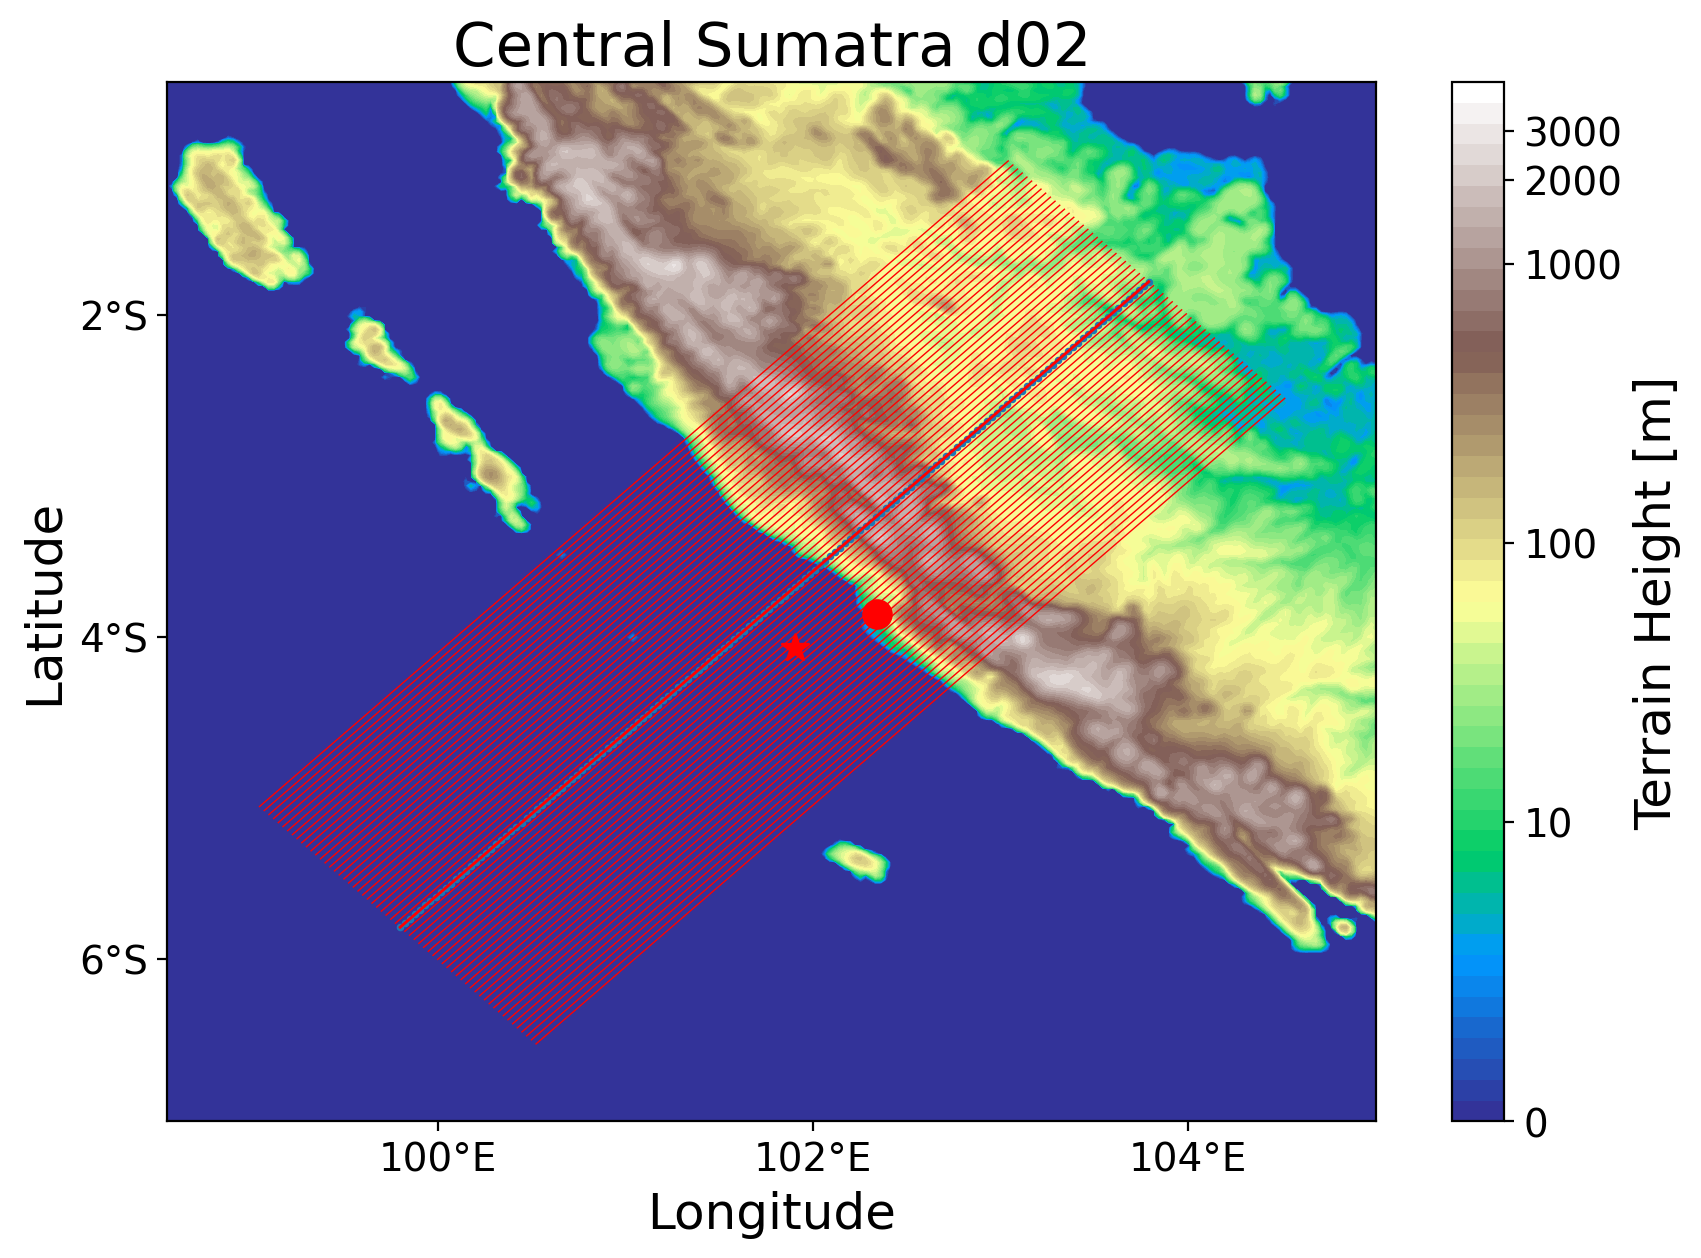

In [13]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_NormalWind_cross.Lat.max()+0.5,da_d02_NormalWind_cross.Lat.min()-0.5]
lon = [da_d02_NormalWind_cross.Lon.min()-0.5,da_d02_NormalWind_cross.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_NormalWind_cross.shape[3])):
	plt.plot(da_d02_NormalWind_cross.Lon[:,i],da_d02_NormalWind_cross.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_NormalWind_cross.Lon[:,int(da_d02_NormalWind_cross.shape[3]/2)],da_d02_NormalWind_cross.Lat[:,int(da_d02_NormalWind_cross.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_NormalWind_cross.Lon[:,int(da_d02_NormalWind_cross.shape[3]/2)],da_d02_NormalWind_cross.Lat[:,int(da_d02_NormalWind_cross.shape[3]/2)],s=3)
# Plot the off-shore radar (R/V Mirai of JAMSTEC)
plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=18)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=14)

ax1.set_xlabel('Longitude',fontsize=18)
ax1.set_ylabel('Latitude',fontsize=18)
ax1.set_title('Central Sumatra d02',fontsize=22)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=14)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=14)

#### Diurnal Composite Normal Wind [d02]

In [1]:
# Data
	# Composite diurnally, and then average over each cross-section
x = da_d02_NormalWind_cross.groupby('Time.hour').mean().mean('Spread')
z = da_d02_RR_cross.groupby('Time.hour').mean().mean('Spread')

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# local_date = da_d02_NormalWind_cross.Time[i] + np.timedelta64(7,'h')
	# Local Timing
	if i > 17:
		LT = i-18
	else:
		LT = i+6
	string = 'Normal Wind at ' + str(LT) + 'LT between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}E) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	# In UTC
	# string = 'Normal Wind at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	ax1.set_title(string)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_DC_Cross_Sumatra_NormalWind_d02_'+str(LT)+'.png',dpi=300)
	mpl.pyplot.close()

NameError: name 'da_d02_NormalWind_cross' is not defined

#### Diurnal Composite Cloud Fraction [d02]

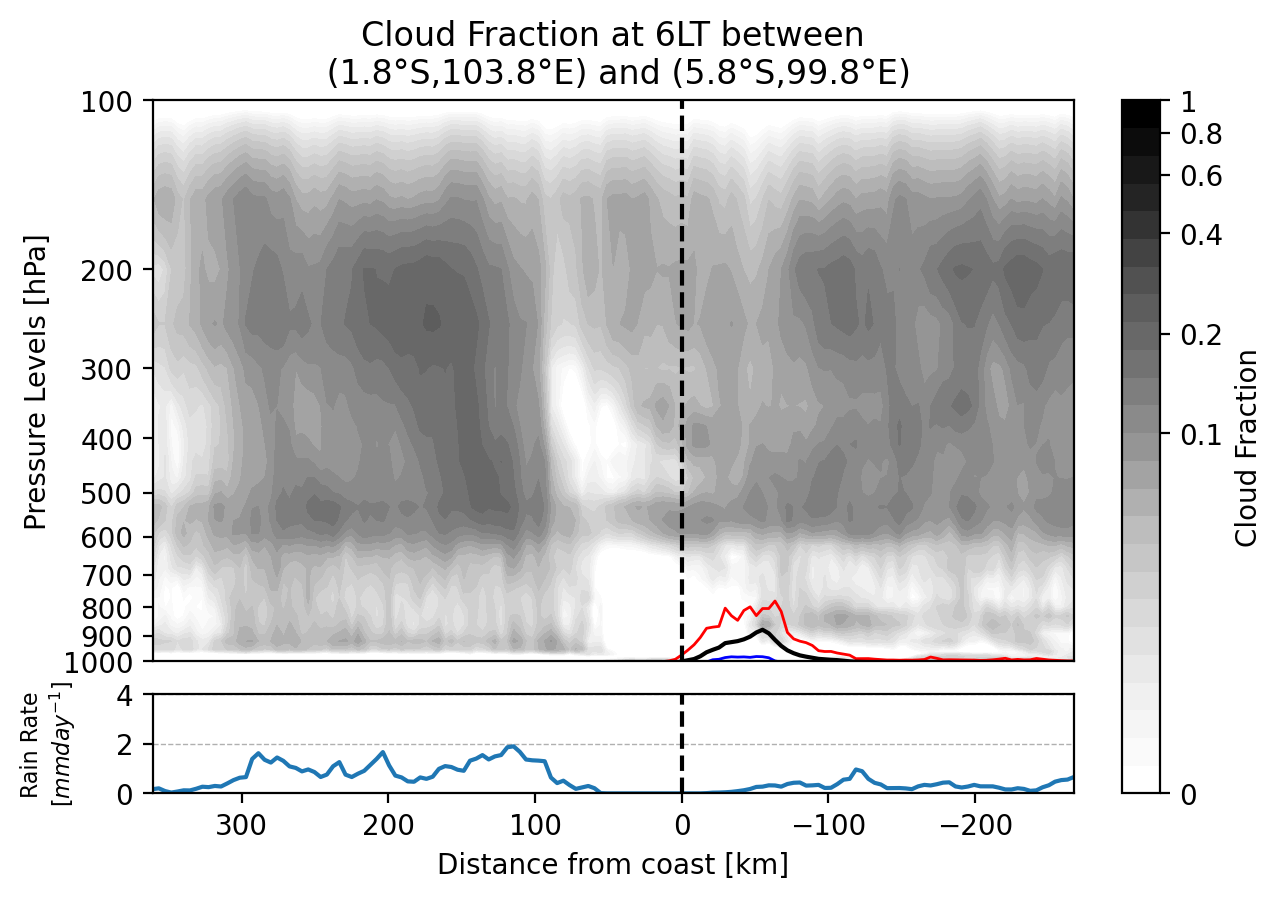

In [101]:
# Data
	# Composite diurnally, and then average over each cross-section
x = da_d02_CLDFRA_cross.groupby('Time.hour').mean().mean('Spread')
z = da_d02_RR_cross.groupby('Time.hour').mean().mean('Spread')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(0,0.525,0.025),
		levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='Greys',
		yscale='log',
		# center=0,
		ylim=[100,1000],
		# alpha=0.4
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# local_date = x.Time[i] + np.timedelta64(7,'h')
	# Local Timing
	if i > 17:
		LT = i-18
	else:
		LT = i+6
	string = 'Cloud Fraction at ' + str(LT) + 'LT between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}E) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	# In UTC
	# string = 'Cloud Fraction at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Cloud Fraction')
	cbar.set_ticks([0,0.1,0.2,0.4,0.6,0.8,1])
	cbar.minorticks_off()
	cbar.set_ticklabels([0,0.1,0.2,0.4,0.6,0.8,1])
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_DC_Cross_Sumatra_CLDFRA_d02_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

#### Diurnal Composite Net CRF [d02]

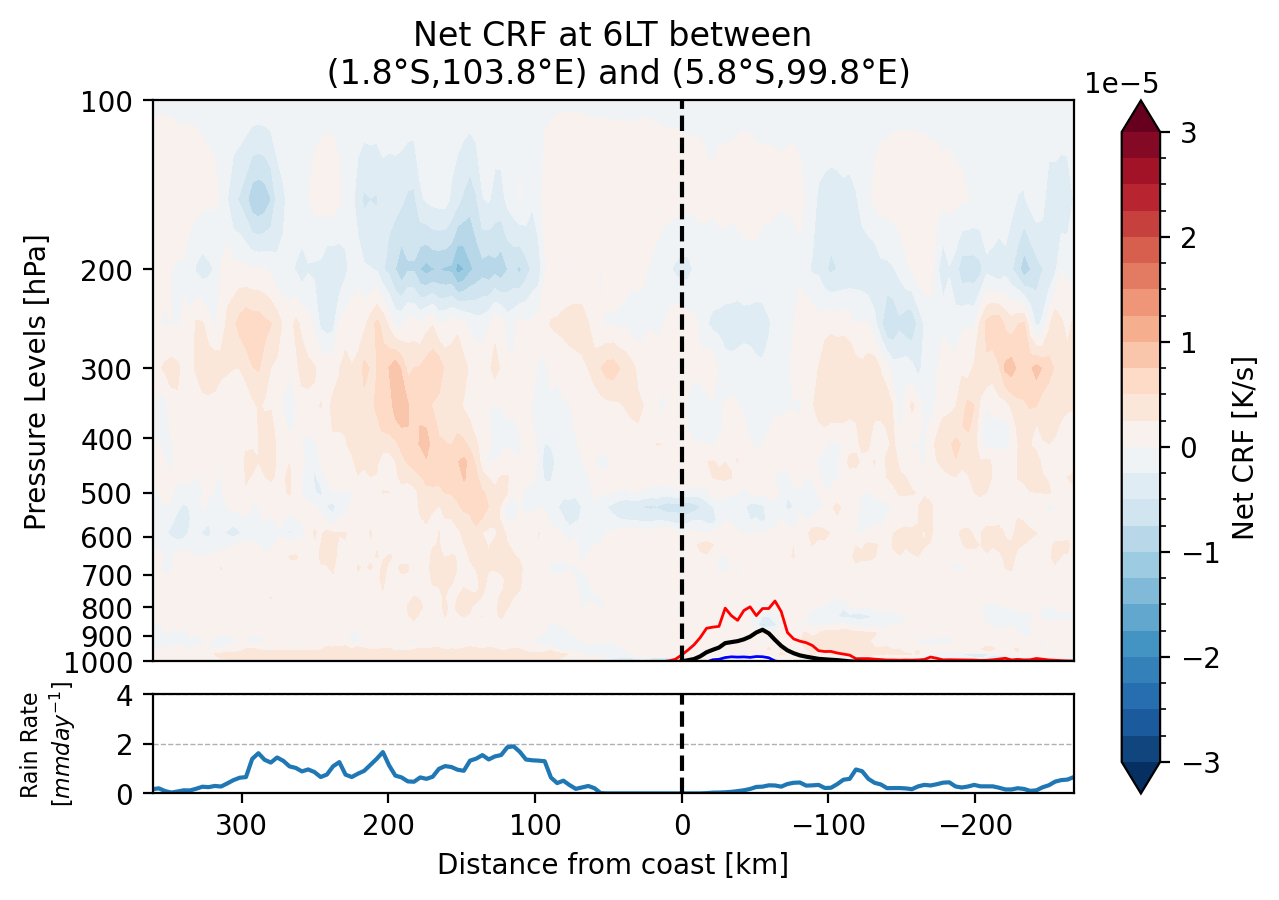

In [100]:
# class MidpointNormalize(mpl.colors.Normalize):
#     def __init__(self, vmin, vmax, midpoint=0, clip=False):
#         self.midpoint = midpoint
#         mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

#     def __call__(self, value, clip=None):
#         normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
#         normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
#         normalized_mid = 0.5
#         x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
#         return np.ma.masked_array(np.interp(value, x, y))

# vmin=-5*10**-5		
# vmax=4*10**-5
# norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

# Data
	# Composite diurnally, and then average over each cross-section
x = da_d02_NetCRF_cross.groupby('Time.hour').mean().mean('Spread')
z = da_d02_RR_cross.groupby('Time.hour').mean().mean('Spread')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-3*10**-5,3.25*10**-5,0.25*10**-5),
		extend='both',
		vmax=3*10**-5,
		vmin=-3*10**-5,
		# norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0),
		cmap='RdBu_r',
		yscale='log',
		ylim=[100,1000],
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# local_date = x.Time[i] + np.timedelta64(7,'h')
	# Local Timing
	if i > 17:
		LT = i-18
	else:
		LT = i+6
	string = 'Net CRF at ' + str(LT) + 'LT between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}E) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	# In UTC
	# string = 'Cloud Fraction at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100,ticks=np.arange(-3*10**-5,4*10**-5,1*10**-5))
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Net CRF [K/s]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_DC_Cross_Sumatra_NetCRF_d02_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

#### Time series of Normal Wind and Rain Rate [d01]

In [140]:
# Data
	# Average over the spread/number fo lines
x = da_d01_NormalWind_cross.mean('Spread')
z = da_d01_RR_cross.mean('Spread')
x2 = da_d01_CLDFRA_cross.mean('Spread')


for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d01,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d01,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d01,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the Normal Wind cross-section data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	local_date = da_d01_NormalWind_cross.Time[i] + np.timedelta64(7,'h')
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'LT between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}E) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	# In UTC
	# string = 'Normal Wind at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	ax1.set_title(string)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_TS_Cross_Sumatra_NormalWind_d01_'+str(local_date.dt.strftime("%Y-%m-%d-%HLT").to_numpy())+'.png',dpi=300)
	mpl.pyplot.close()

#### Time series of Normal Wind and Rain Rate [d02]

In [139]:
# Data
	# Average over the spread/number fo lines
x = da_d02_NormalWind_cross.mean('Spread')
z = da_d02_RR_cross.mean('Spread')
x2 = da_d02_CLDFRA_cross.mean('Spread')


for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the Normal Wind cross-section data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	local_date = da_d02_NormalWind_cross.Time[i] + np.timedelta64(7,'h')
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'LT between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}E) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	# In UTC
	# string = 'Normal Wind at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	ax1.set_title(string)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_TS_Cross_Sumatra_NormalWind_d02_'+str(local_date.dt.strftime("%Y-%m-%d-%HLT").to_numpy())+'.png',dpi=300)
	mpl.pyplot.close()

#### Time Series of Rain Rate (d01 RR)

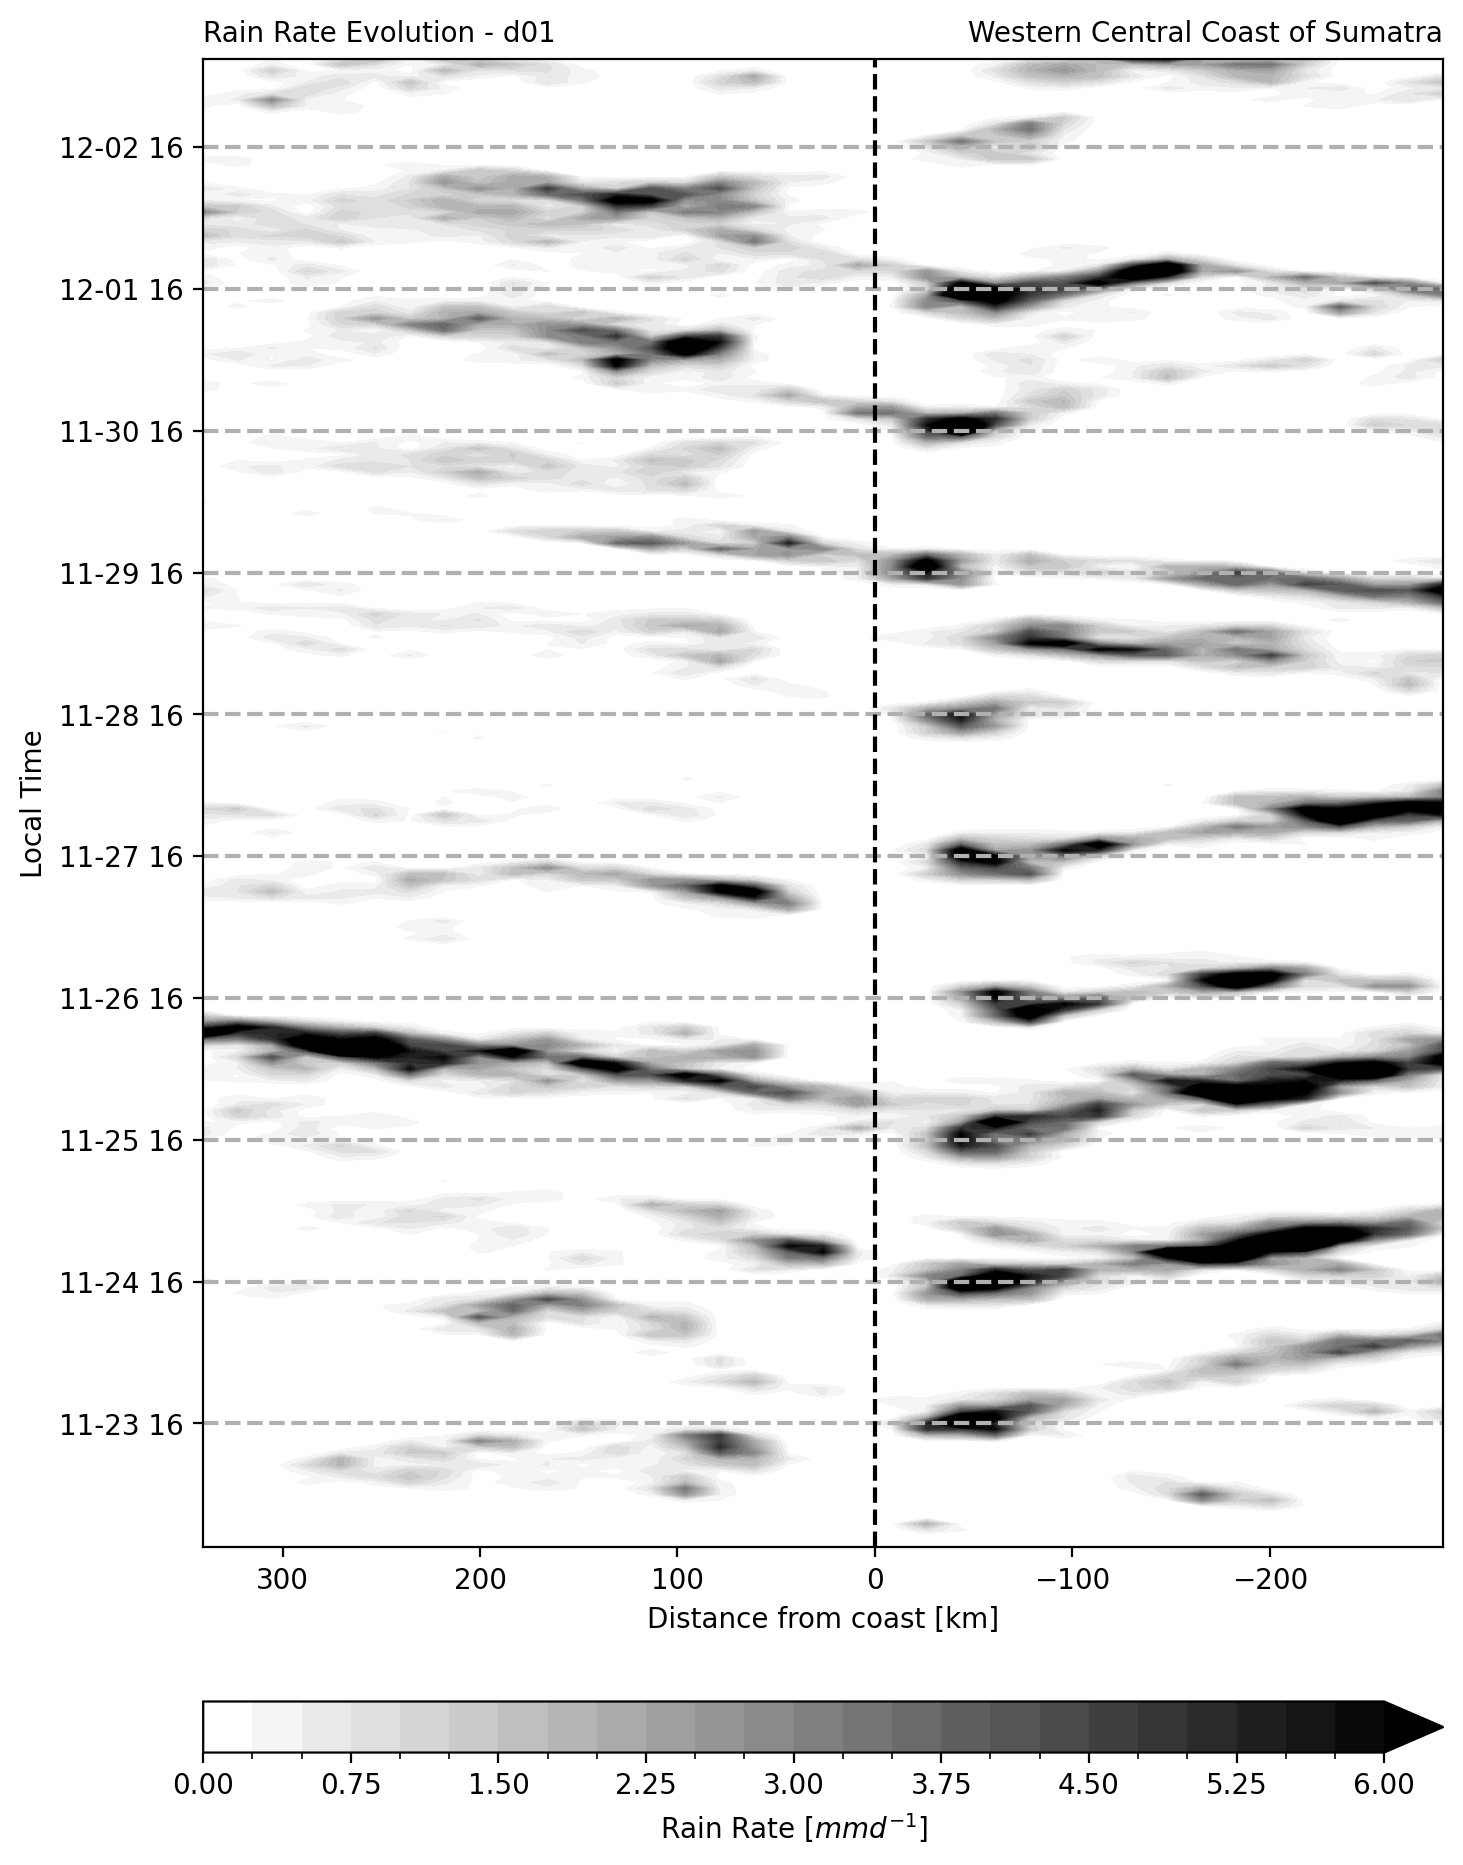

In [319]:
fig = plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.2, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Average over each cross-section
x1 = da_d01_RR_cross
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.mean('Spread')

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)

# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x1.Time[21::24].values)
ax1.set_yticklabels(x1.Time[21::24].dt.strftime("%m-%d %H").values)
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d01', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
# Create grids
# ax1.grid(linestyle='--', axis='x', linewidth=1.5)
ax1.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')


#### Diurnal Composite Rain Rate (d02 RR)

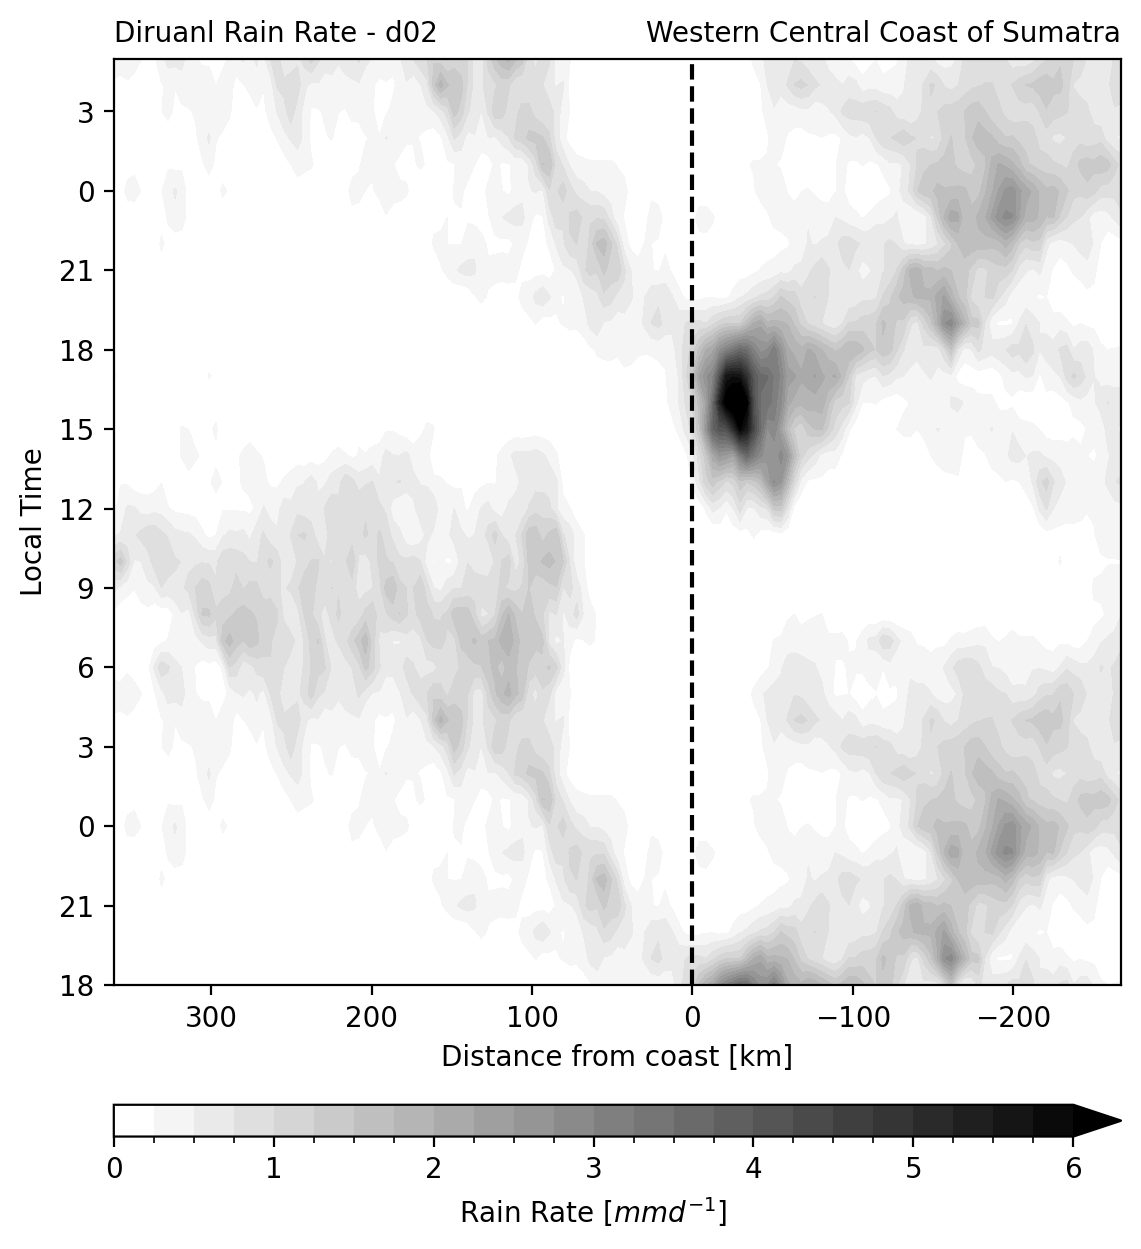

In [152]:
fig = plt.figure(figsize=(6.5,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Composite diurnally, and then average over each cross-section
x1 = da_d02_RR_cross
# Switch to local time
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.groupby('Time.hour').mean().mean('Spread')
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

# Plot the cross-sectional data
cf1 = x2.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x2.hour[0::3].values)
ax1.set_yticklabels(yticks[0::3])
# Set titles/labels
ax1.set_title('Diruanl Rain Rate - d02', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]')



#### Time Series of Rain Rate (d02 RR)

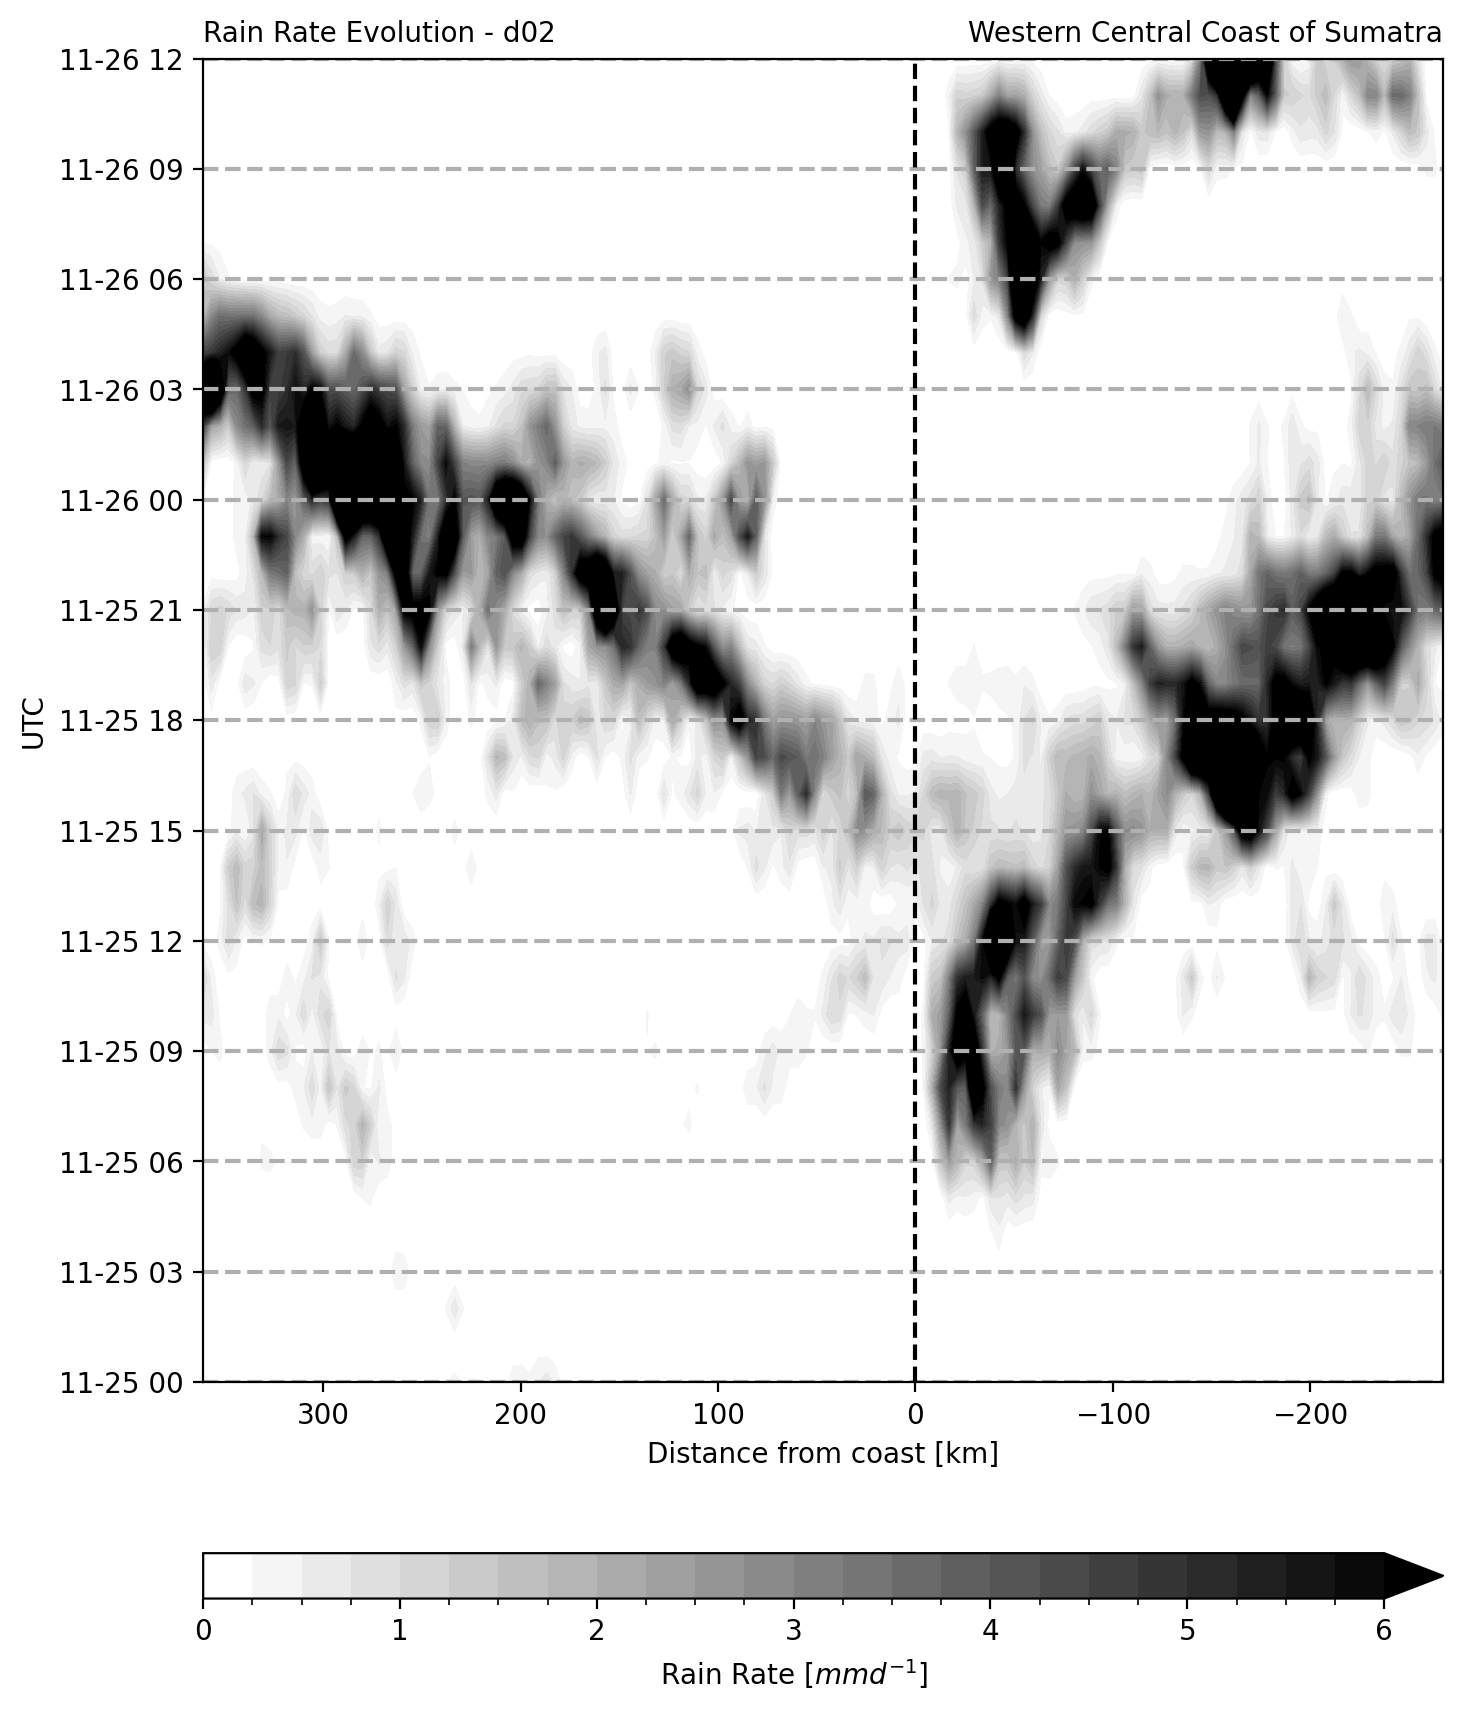

In [171]:
fig = plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Average over each cross-section
x1 = da_d02_RR_cross.mean('Spread')

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	ylim=[x1.Time[60],x1.Time[96]],
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)

# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax1.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[60:97:3].values)
ax1.set_yticklabels(x1.Time[60:97:3].dt.strftime("%m-%d %H").values)
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d02', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
# Create grids
# ax1.grid(linestyle='--', axis='x', linewidth=1.5)
ax1.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]')



# Hovmoller diagram (d01)

### Rain + 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4*2, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(15,75,5),
	vmin=15, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Rain

Text(0, 0.5, '')

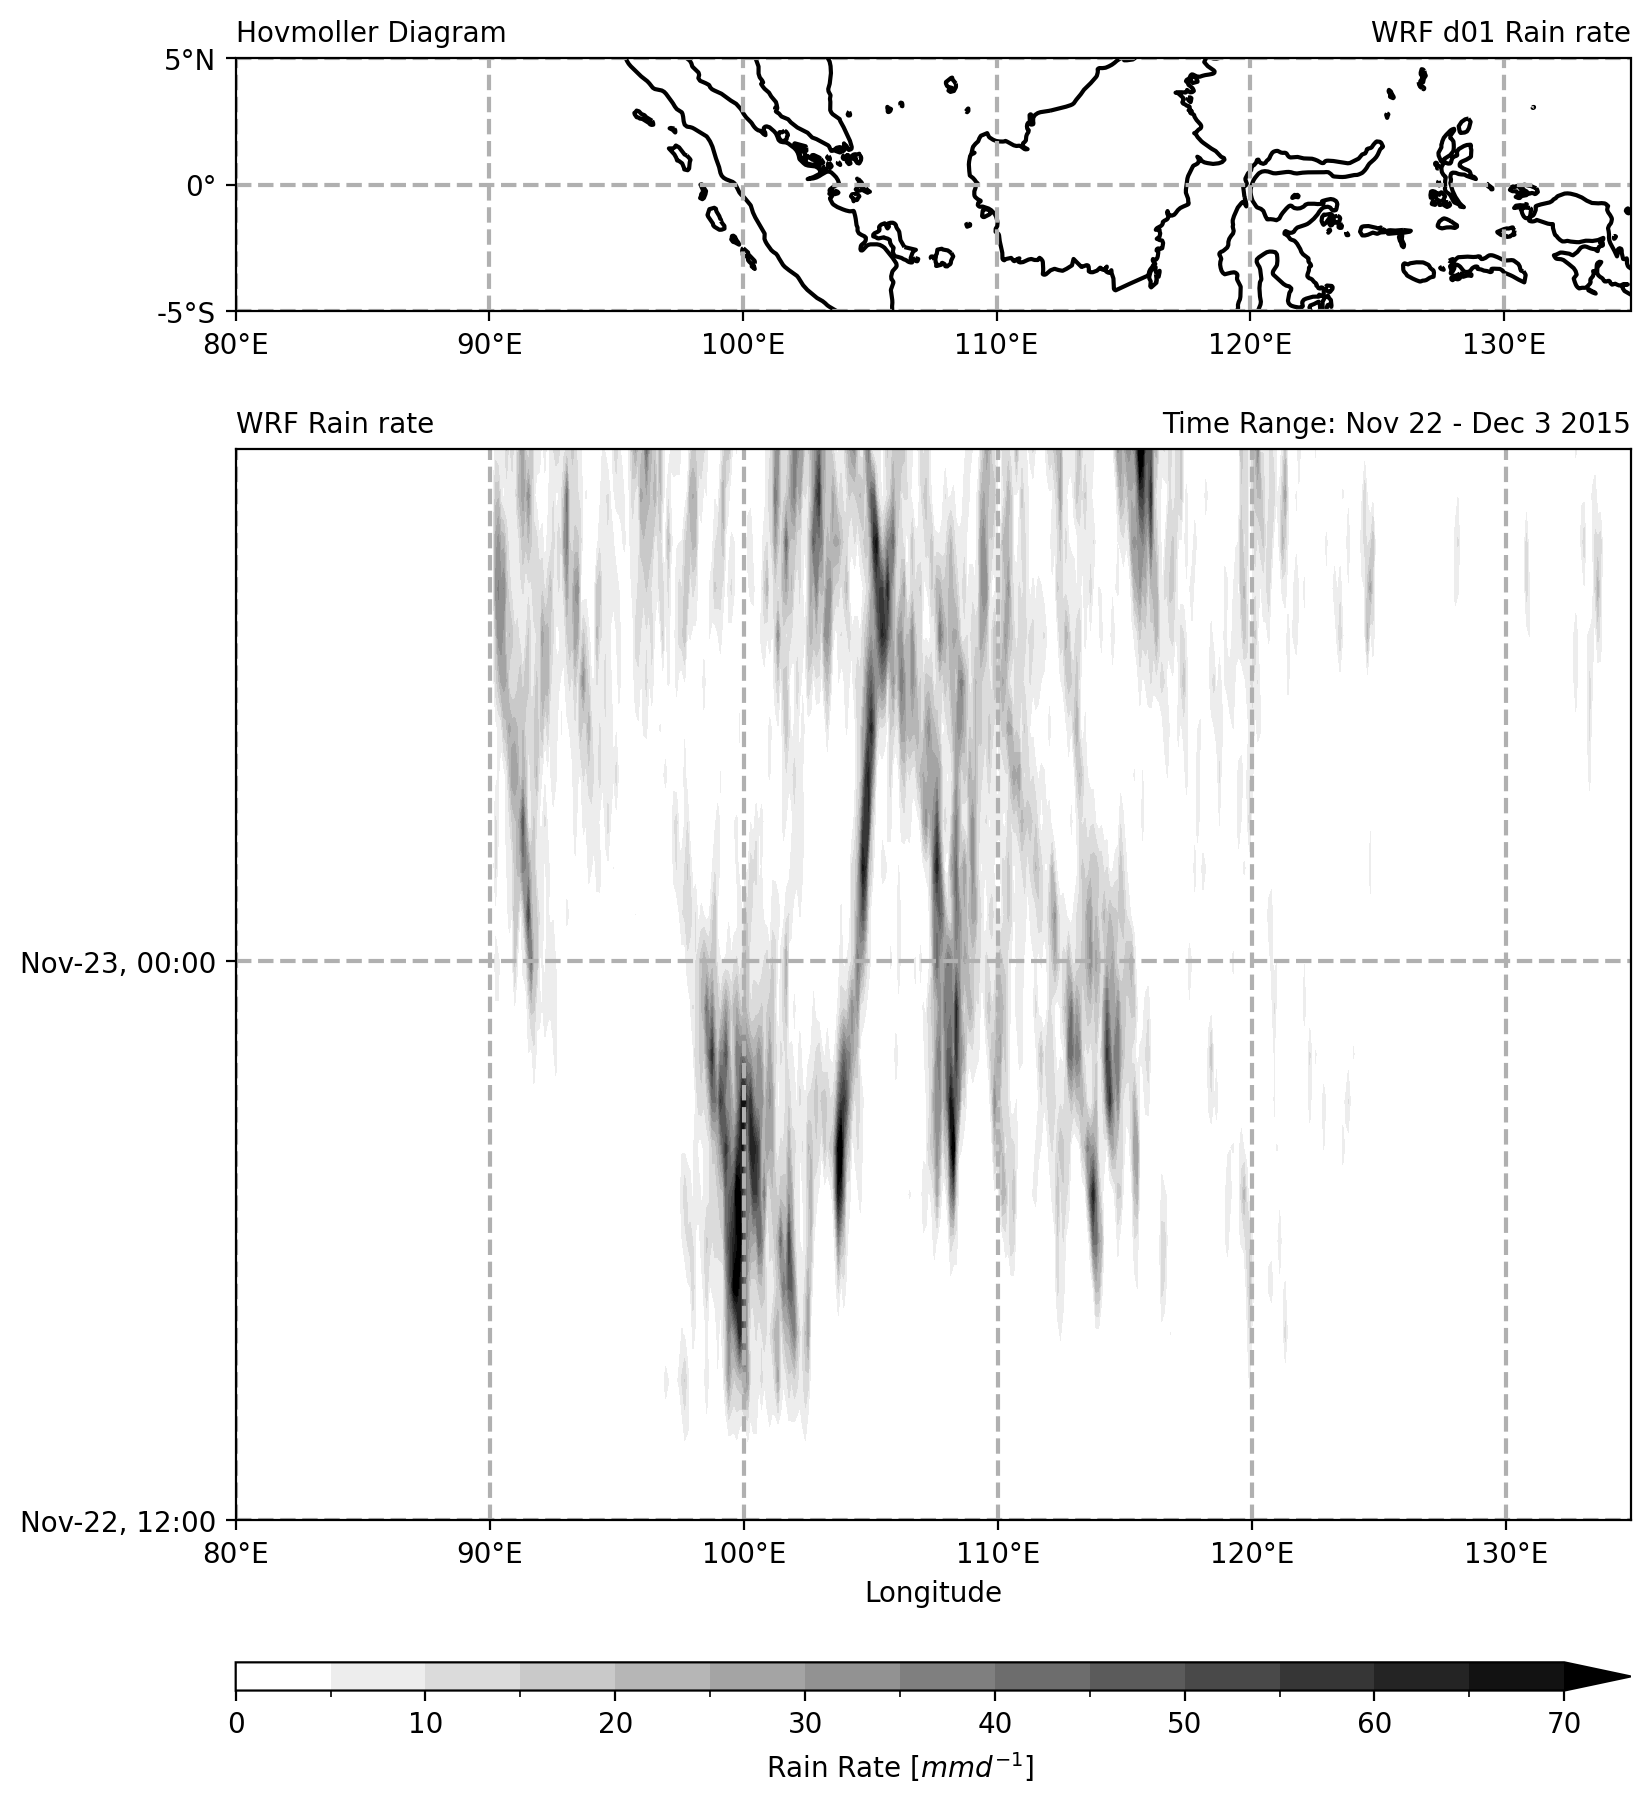

In [21]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d01 Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	# levels=np.append(0,np.logspace(0,2,15)),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d01_U850.where(
    (da_d01_U850.XLAT>lat_avg_bound[0]) & (da_d01_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, :])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')

# Set titles/labels
ax2.set_title('850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

# Hovmoller Diamgram (d02)

### Rain + 850hPa zonal winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF Rain rate & 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d02_U850.where(
    (da_d02_U850.XLAT>lat_avg_bound[0]) & (da_d02_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray',
	levels=np.arange(20,75,5),
	vmin=20, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, 0])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Rain rate & 850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Rain

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d02 Rain rate', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,75,5),
	vmin=0, vmax=70,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-28 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### 850hPa Zonal Winds

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])
# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF 850-hPa zonal winds', loc='right', fontsize=10)


#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the 850 hPa zonal winds between the lat_avg_bounds
x2 = da_d02_U850.where(
    (da_d02_U850.XLAT>lat_avg_bound[0]) & (da_d02_U850.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')
# Apply a rolling center mean for zonal winds to smooth it out
x2 = x2.rolling(Time=4, min_periods=1, center=True).mean()
x2 = x2.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x2 = x2.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the zonal winds
cf1 = x2.plot.contourf(
	# x = 'west_east',
    # y = 'Time',
    ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',		# _r reverses the colorbar order!
	levels=np.arange(-12,13,2),
	vmin=-12, vmax=12,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Zonal wind colorbar
ax3 = fig.add_subplot(gs[4, :])
cbar1 = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0.04, aspect=75, extend='max')
cbar1.set_label('Zonal wind [$m s^{-1}$]')

# Set titles/labels
ax2.set_title('850-hPa zonal winds', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Diurnal Hovmoller Diagram d01

Text(0, 0.5, 'UTC')

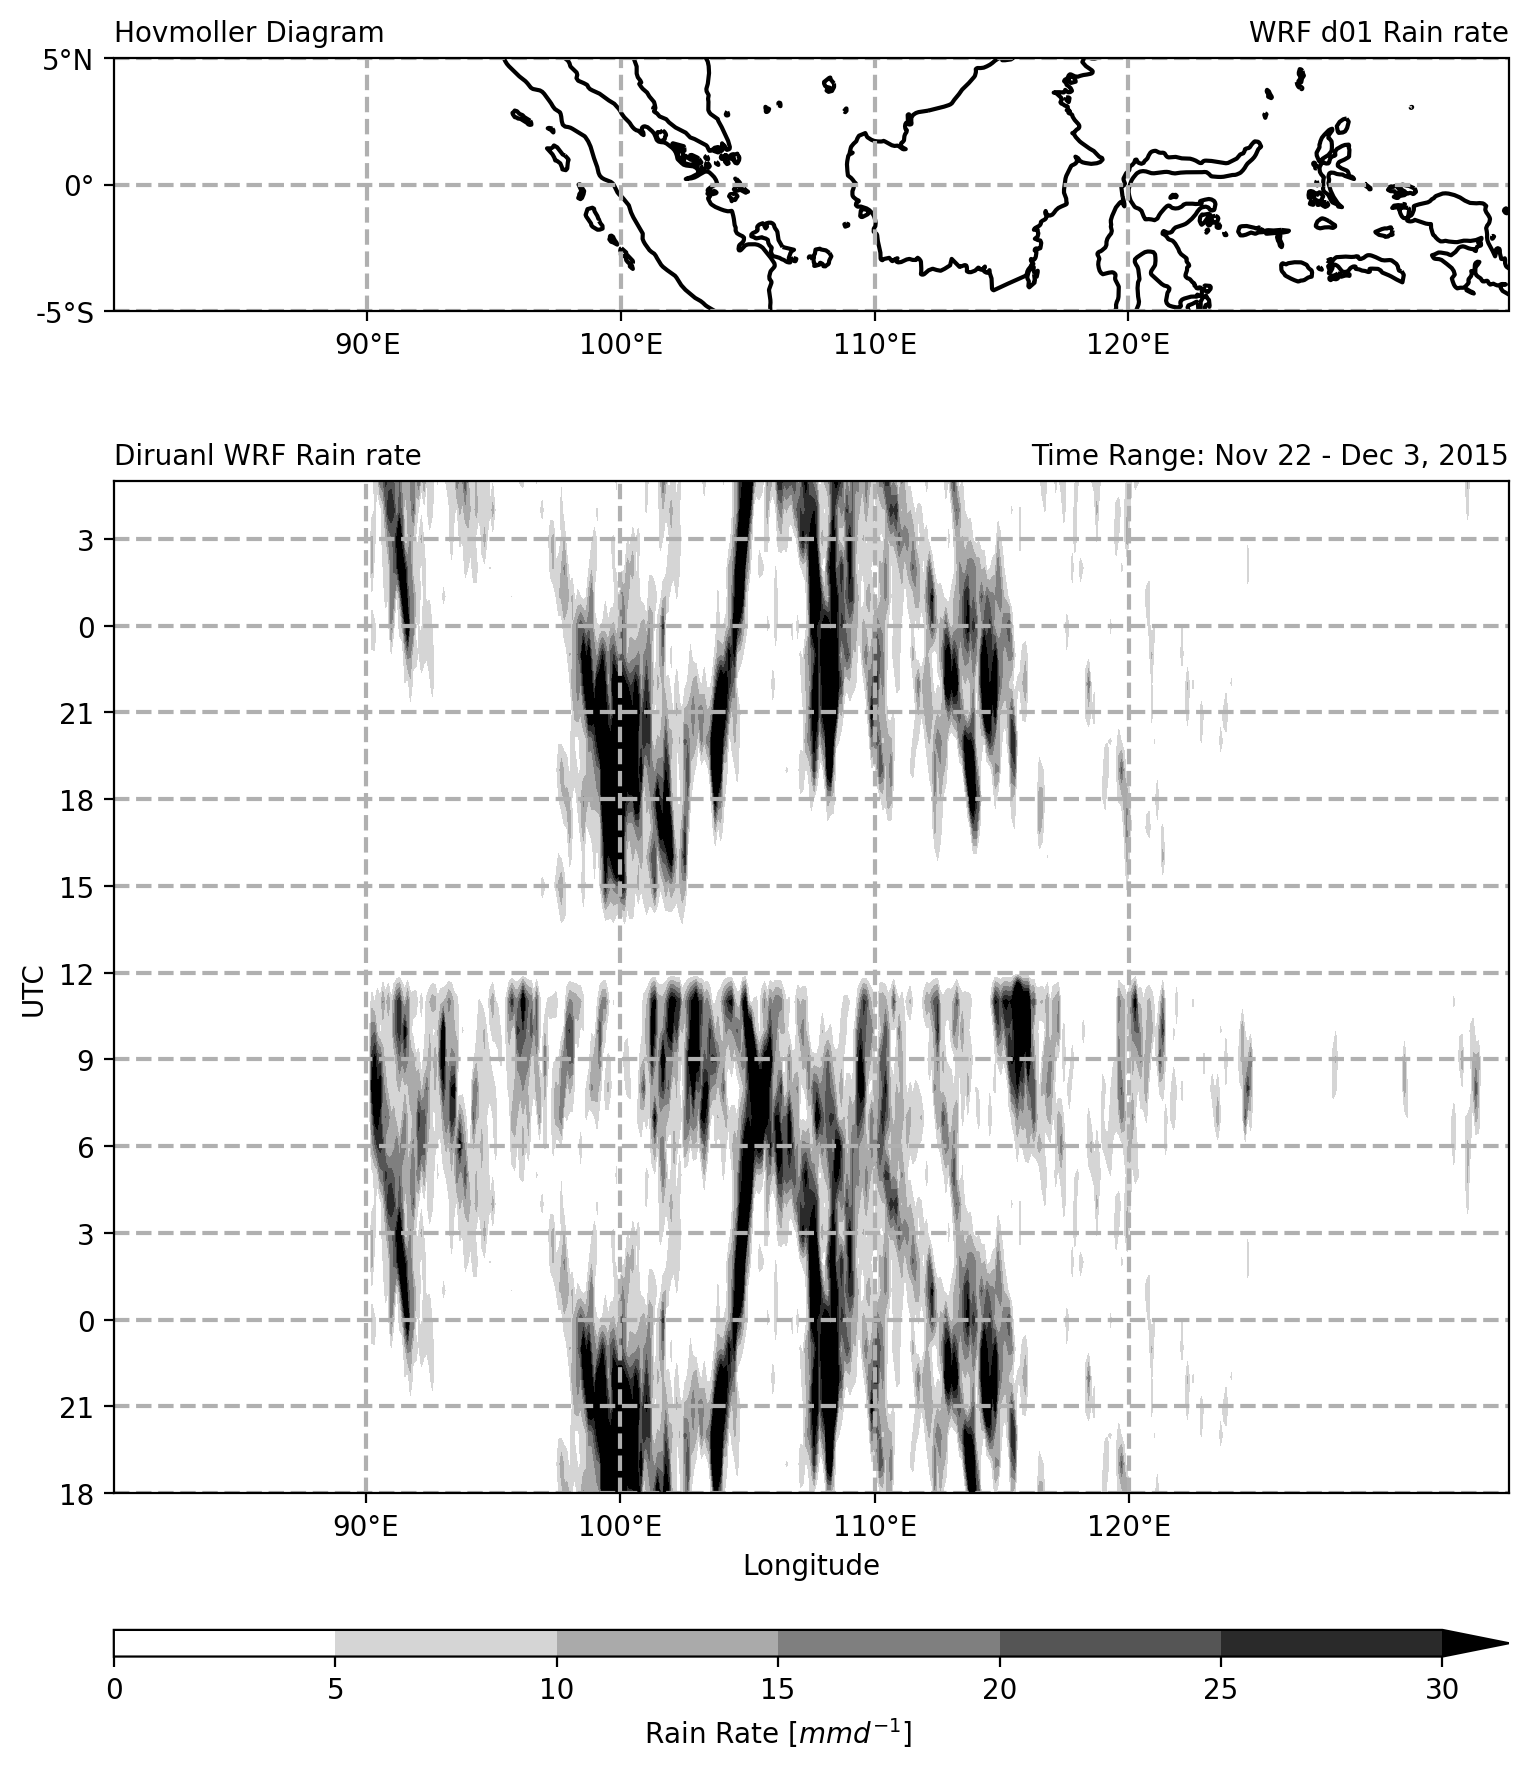

In [27]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.25,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d01 Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d01_RR.where((da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
x1 = x1.groupby('XTIME.hour').mean()
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x2.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,35,5),
	vmin=0, vmax=30,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Diruanl WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(x2.hour[0::3].values)
ax2.set_yticklabels(yticks[0::3])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')

In [28]:
yticks[0::3]

array([18, 21,  0,  3,  6,  9, 12, 15, 18, 21,  0,  3])

### Diurnal Hovmoller Diagram d02

In [ ]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.25,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d02 Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into mm/day
x1 = da_d02_RR.where((da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24
x1 = x1.groupby('XTIME.hour').mean()
# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d02.XLONG.values[0,0,:]))
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x2.plot.contourf(
    x = 'west_east',
    y = 'hour',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='gray_r',
	levels=np.arange(0,35,5),
	vmin=0, vmax=30,
	extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('Diruanl WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22 - Dec 3, 2015', loc='right', fontsize=10)
ax2.set_title('', loc='center')

ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(x2.hour[0::3].values)
ax2.set_yticklabels(yticks[0::3])
ax2.set_xlabel('Longitude')
ax2.set_ylabel('UTC')

### Diurnal average of rain rate over Ocean and Land

In [ ]:
# Uses the same d02 domain box for all

#################### d01 ####################
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1])
		     &(da_d01_RR.XLONG>lon_bound_d02[0])&(da_d01_RR.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1L = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1W = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1A = da_avg.groupby('Time.hour').mean()


#################### d02 ####################
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1])
		     &(da_d02_RR.XLONG>lon_bound_d02[0])&(da_d02_RR.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2L = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2W = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2A = da_avg.groupby('Time.hour').mean()


In [ ]:
# Uses the same d02 domain box for all

#################### d01 ####################
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1])
		     &(da_d01_RR.XLONG>lon_bound_d01[0])&(da_d01_RR.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1L = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1W = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1A = da_avg.groupby('Time.hour').mean()


#################### d02 ####################
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1])
		     &(da_d02_RR.XLONG>lon_bound_d02[0])&(da_d02_RR.XLONG<lon_bound_d02[1]),drop=False)*24

# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2L = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2W = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2A = da_avg.groupby('Time.hour').mean()


In [ ]:
fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1L.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='WRF-Land'
)
b = x1W.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='WRF-Water'
)
c = x1A.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='k',
    linewidth=2,
    linestyle = '--',
	label='WRF-Avg'
)

# d = x2L.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='WRF-Land'
# )
# e = x2W.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     ylim=[0,40],
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='WRF-Water'
# )
# e = x2A.plot.line(
#     ax=ax1,
#     xlim=[0,23],
#     ylim=[0,40],
#     color='k',
#     linewidth=2,
#     linestyle = '--',
# 	label='WRF-Avg'
# )

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
# ax1.set_title('WRF-Diurnal Averaged Rain Rate [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('WRF-Diurnal Averaged Rain Rate [5°S-5°N], d01:[80-135°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper left')


In [ ]:
# d01
x1 = da_d01_RR.where(
    (da_d01_RR.XLAT>lat_avg_bound[0]) & (da_d01_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24

# d02
x2= da_d02_RR.where(
    (da_d02_RR.XLAT>lat_avg_bound[0]) & (da_d02_RR.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north').mean('west_east')*24

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x1.plot.line(
    ax=ax1,
    xlim=[0,x1.shape[0]-1],
    # x_ticks=x1.XTIME,
    color='peru',
    linewidth=2,
    linestyle = '-',
)
b = x2.plot.line(
    ax=ax1,
    # xlim=[0,23],
    ylim=[0,40],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF-Large-Scale Rain Rate Evolution [5°S-5°N]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')

# ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
# t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax1.set_xticks(x1.Time[12::24])
ax1.set_xticklabels(np.array(x1.XTIME[12::24].dt.strftime("%m-%d")))
ax1.set_xlabel('')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(['d01','d02'], loc='upper right')


In [ ]:
######## Control ########

# Uses the same d02 domain box for all
#################### d01 ####################
da = da_d01_RR.where((da_d01_RR.XLAT>lat_bound[0])&(da_d01_RR.XLAT<lat_bound[1])
		     &(da_d01_RR.XLONG>lon_bound_d01[0])&(da_d01_RR.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x1L = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x1L = x1L.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x1W = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x1W = x1W.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x1A = da.mean('south_north').mean('west_east')
x1A = x1A.assign_coords(Time=(['Time'],da.XTIME.values))

#################### d02 ####################
da = da_d02_RR.where((da_d02_RR.XLAT>lat_bound[0])&(da_d02_RR.XLAT<lat_bound[1])
		     &(da_d02_RR.XLONG>lon_bound_d02[0])&(da_d02_RR.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x2L = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x2L = x2L.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x2W = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x2W = x2W.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x2A = da.mean('south_north').mean('west_east')
x2A = x2A.assign_coords(Time=(['Time'],da.XTIME.values))


In [ ]:

#### PLOTTING ####

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

d = x2L.plot.line(
    ax=ax1,
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='WRF-Land'
)
e = x2W.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='WRF-Water'
)
f = x2A.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='WRF-Avg'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF Rain Rate Evolution [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22 - Dec 3', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(x1L.Time[12::24])
ax1.set_xlim(x1L.Time[0],x1L.Time[-1])
ax1.tick_params(rotation=0)
ax1.set_xticklabels(np.array(x1L.Time[12::24].dt.strftime("%m-%d")),horizontalalignment='center')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.set_xlabel('')
ax1.legend(loc='upper left')


In [ ]:
# # Data
num_grids = 3
y = da_d02_RR

if y.shape[2] == da_d01_RR.shape[2]:
    a = 'd01'
else:
    a = 'd02'

x = y.groupby('XTIME.hour').mean('Time')
x = x.rolling(south_north=num_grids, min_periods=1, center=True).mean()
x = x.rolling(west_east=num_grids, min_periods=1, center=True).mean()
x = x.idxmax('hour',keep_attrs=True)

fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]

x = xr.DataArray(
    data = x,
    dims = ['south_north','west_east'],
    coords = dict(
        XLAT=('south_north',y.XLAT[0,:,0].values),
        XLONG=('west_east',y.XLONG[0,0,:].values))
)

# x2 = da_d02_RR.groupby('XTIME.hour').mean('Time').idxmax('hour',keep_attrs=True)

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,24]
dl = 1

cf = x.plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='hsv',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )
ax1.set_title('WRF ' + a + ' Diurnal Maximum in UTC',loc='center')
ax1.set_title('Center smooth # of grids: ' + str(num_grids),loc='right')

ax1.set_xlabel('')
ax1.set_ylabel('')
ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar.set_label('UTC')


### Sumatra Diurnal Offshore Propagation

## MOVIES/GIFS below

In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_RR[36:60,...].where(
    (da_d02_RR[36:60,...].XLAT>lat_avg_bound[0]) & (da_d02_RR[36:60,...].XLAT<lat_avg_bound[1]),
    drop=True)*24    # mm/day

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5


cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF rain rate evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.XTIME[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('plots/WRF'+np.datetime_as_string(x.XTIME[i],unit='m')+'.png',dpi=300)


In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_RR.groupby('XTIME.hour').mean('Time')*24    # mm/day
x = x.assign_coords(west_east=(['west_east'],da_d02_RR.XLONG.values[0,0,:]),
                south_north=(['south_north'],da_d02_RR.XLAT.values[0,:,0]))
x = x.where((x.south_north>lat_avg_bound[0])&(x.south_north<lat_avg_bound[1]), drop=True)

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='w', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [0,85]
dl = 5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='west_east',
        y='south_north',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')


for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='jet',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=0, vmax=levels[1]-dl,
        extend='max',
        x='west_east',
        y='south_north',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF rain rate evolution',loc='left')
    ax1.set_title(str(x.hour[i].values) + ' UTC')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/WRF_DC_RR_'+str(x.hour[i].values)+'.png',dpi=300)


In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_U850[36:60,...].where(
    (da_d02_U850[36:60,...].XLAT>lat_avg_bound[0]) & (da_d02_U850[36:60,...].XLAT<lat_avg_bound[1]),
    drop=True)    # m/s
x

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-12,13]
dl = 1


cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('850-hPa Zonal Wind [$m s^{-1}$]')

for i in range(1):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF 850-hPa evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.XTIME[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('plots/WRF_U_'+np.datetime_as_string(x.XTIME[i],unit='m')+'.png',dpi=300)


In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]


x = da_d02_U850.groupby('XTIME.hour').mean('Time')   # m/s
x = x.assign_coords(west_east=(['west_east'],da_d02_U850.XLONG.values[0,0,:]),
                south_north=(['south_north'],da_d02_U850.XLAT.values[0,:,0]))
x = x.where((x.south_north>lat_avg_bound[0])&(x.south_north<lat_avg_bound[1]), drop=True)

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-12,13]
dl = 1


cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='west_east',
        y='south_north',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('850-hPa Zonal Wind [$m s^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='max',
        x='west_east',
        y='south_north',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF 850-hPa Zonal Wind evolution',loc='left')
    ax1.set_title(str(x.hour[i].values) + ' UTC')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/WRF_DC_U850_'+str(x.hour[i].values)+'.png',dpi=300)


In [ ]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.1,.8,.1])
lat_avg_bound = [-5,5]
# Data
x = da_d02_U200[36:60,...].where(
    (da_d02_U200[36:60,...].XLAT>lat_avg_bound[0]) & (da_d02_U200[36:60,...].XLAT<lat_avg_bound[1]),
    drop=True)    # m/s

# Set parameters and labels
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_tick_labels = [u'5\N{DEGREE SIGN}S',u'2.5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'2.5\N{DEGREE SIGN}N',u'5\N{DEGREE SIGN}N']

ax1 = fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d02[0], lon_bound_d02[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Plot the coast lines
ax1.coastlines(linewidth=0.5, color='k', resolution='50m')  # cartopy function
ax1.set_xticks([90,100,110,120])
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks([-5,-2.5,0,2.5,5])
ax1.set_yticklabels(y_tick_labels)
levels = [-20,22.5]
dl = 2.5

cf = x[0,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='min',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
    )


ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max')
cbar.set_label('200-hPa Zonal Wind [$m s^{-1}$]')

for i in range(24):
    # ax1.clear()
    cf = x[i,:,:].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0],levels[1],dl),
        vmin=levels[0], vmax=levels[1]-dl,
        extend='min',
        x='XLONG',
        y='XLAT',
        xlim=[lon_bound_d02[0], lon_bound_d02[1]],
        ylim=[lat_bound[0], lat_bound[1]]
        ) 
    ax1.set_title('WRF 200-hPa Zonal Wind evolution',loc='left')
    ax1.set_title(np.datetime_as_string(x.XTIME[i],unit='m'))
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    # plt.savefig('temp_plots/WRF_U200_'+np.datetime_as_string(x.XTIME[i],unit='m')+'.png',dpi=300)
